In [2]:
import os
os.environ['APP_HOST'] = 'http://192.168.60.25:8005'

In [3]:
import numpy as np
import pandas as pd

from abc import abstractmethod
from razor import inputs,outputs,Block,Pipeline
from razor.core.blocks.models import ModelBlock

Couldn't setup user context. You may not be running this in the platform's Jupyter
Failed to load configuration file. Using default configs


### Building a ML Model

#### Problem 
You want to create a ML model. For example, there is a dataset on which you want to build a classifier model using logistic regression. 


#### Solution
Create a Model Block for LogisticRegression which will perform the logistic regression operation

<i><u>Example</u></i><br/>
1. Create a generic classifer block to handle the training and inference of a model
    * `fit` - This function contains the logic needed to train the model
    * `Evaluate` - This function contains the logic needed to evaluate the model using test datasets


In [4]:
from abc import abstractmethod
import pickle
from sklearn import metrics


class Classifier(ModelBlock):

    @abstractmethod
    def create_model(self, **kwargs):
        """
        Should create and return the model object
        """
    @abstractmethod
    def attribute_func(self, *args, **kwargs):
        """
        Should return the attribute values
        """
        
    @abstractmethod
    def operation_func(self, *args, **kwargs):
        """
        Should return the operation reuslts
        """

    def load_saved_model(self, path):
        self.model = pickle.load(open(self.save_path(path=path), 'rb'))

    def save_model(self, path):
        pickle.dump(self.model, open(self.save_path(path=path), 'wb'))

    def persist_train(self, x_data, y_data, path):
        self.load_saved_model(path)
        self.fit(x_data, y_data)

    def transform(self, x_data, predictions):
        predictions.put(self.model.predict(x_data))
        
        
    def fit(self, x_data, y_data, test_x_data, test_y_data, metric_function, average, operation, predictions, attribute, model_attributes, path):
        if path is not None and len(path) != 0:
            try:
                self.load_saved_model(path)
            except:
                pass
            
        pred = self.operation_func(x_data=x_data, y_data=y_data, test_x_data=test_x_data, test_y_data=test_y_data,
                                   operation=operation, metric_function=metric_function, average=average)
        predictions.put([pred] if isinstance(pred, (int, float, str)) else pred)

        k = self.model
        if attribute is not None and len(attribute) != 0:
            attr_value = self.attribute_func(attribute)
            print(f"{attribute}: ", attr_value)
            model_attributes.put([attr_value] if isinstance(attr_value, (int, float, str)) else attr_value)
            
        if all(v is not None for v in [x_data, y_data]) or all(v is not None for v in [test_x_data, test_y_data]) and operation != "evaluate":
            if test_x_data is None:
                test_x_data, test_y_data = x_data, y_data
            self.evaluate(test_x_data, test_y_data, metric_function, average)


    def evaluate(self, test_x_data, test_y_data, metric_function, average):
        metric_func = {"accuracy_score": metrics.accuracy_score,
                       "precision_score": metrics.precision_score,
                       "recall_score": metrics.recall_score,
                       "f1_score": metrics.f1_score,
                       "confusion_matrix": metrics.confusion_matrix}
        metric_function = [metric_function] if not isinstance(metric_function, list) else metric_function
        final_metrics = []
        for _metric_function in metric_function:
            eval_metric = metric_func.get(_metric_function, None)
            if _metric_function not in ["accuracy_score", "confusion_matrix"]:
                _metric_value = eval_metric(test_y_data, self.model.predict(test_x_data), average=average)
            else:
                _metric_value = eval_metric(test_y_data, self.model.predict(test_x_data))
            print(f'{_metric_function}: ', _metric_value)
            final_metrics.append(_metric_value)

        return (final_metrics if len(final_metrics) > 1 else final_metrics[0])

2. Create an instance of `LogisticRegression` class with following parameters and train the model by invoking execute():

    * `penalty` - Specify the norm used in the penalization (default= 'l2').
    * `tol` - Specify tolerance for stopping criteria (default=0.0001).
    * `C` - Specify regularization parameter (default=1.0).
    * `class_weight` - Weightage to be given to each class in the data (default=None).
    * `random_state` - Seed value of the random number generator (default=None).
    * `solver` - Specify optimization algorithm to use (default='lbfgs').
    * `max_iter` - Maximum iterations for the solvers to converge (default=100).
    * `n_jobs` - Specify number of CPU cores to be used when parallelizing (default=None).
    * `x_data` - Data on which the model is to be trained.
    * `y_data` - Target values corresponding to each data point in train data.
    * `test_x_data` - Test data on which the model is to be evaluated.
    * `test_y_data` - Test target values corresponding to each data point in `test_x_data`.
    * `operation` - Defines what operation to perform.
         * For training model - `fit`
         * For Predicting model - `predict`
         * For evaluating model - `evaluate`
    * `attribute` - Specify suitable attribute from the following, to be found from the trained model.<br>
         `classes_`, `coef_`, `intercept_`, `n_iter_`
    * `metric_function` - Specify suitable evaluation metric from the folloeing, that best suits for the problem that you are dealing with.
         `confusion_matrix`, `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `roc_curve` 
    * `path` - Specify the path where the trained model is to be saved.

In [5]:
from sklearn.linear_model import LogisticRegression as Logrec

@inputs.atomic.generic('penalty', doc="{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}", default= 'l2')
@inputs.atomic.generic('dual', default=False)
@inputs.atomic.generic('tol', default=0.0001)
@inputs.atomic.generic('C', default=1.0)
@inputs.atomic.generic('fit_intercept', default=True)
@inputs.atomic.generic('intercept_scaling', default=1)
@inputs.atomic.generic('class_weight', default=None)
@inputs.atomic.generic('random_state', default=None)
@inputs.atomic.generic('solver', default='lbfgs')
@inputs.atomic.generic('max_iter', default=100)
@inputs.atomic.generic('multi_class', default='auto')
@inputs.atomic.generic('verbose', default=0)
@inputs.atomic.generic('warm_start', default=False)
@inputs.atomic.generic('n_jobs', default=None)
@inputs.atomic.generic('l1_ratio', default=None)
@inputs.atomic.generic('mode', default="FIT")
@inputs.atomic.generic('operation', default="fit",
                       doc="fit, decision_function, densify, predict, predict_proba, predict_log_proba, sparsify, evaluate, score",
                       required=True)
@inputs.atomic.generic('attribute', default=None,
                       doc="classes_, coef_, intercept_, n_iter_")
@inputs.atomic.generic("x_data")
@inputs.atomic.generic("y_data")
@inputs.atomic.generic("test_x_data", required=False)
@inputs.atomic.generic("test_y_data", required=False)
@inputs.atomic.generic("metric_function", default="accuracy_score")
@inputs.atomic.generic("average", default="binary")
@inputs.atomic.generic("path", default=None)
@outputs.atomic.generic("predictions")
@outputs.atomic.generic("model_attributes")
class LogisticRegression(Classifier):
    """
        Logistic Regression from sklearn
    """
    def create_model(self, penalty, dual, tol, C, fit_intercept, intercept_scaling, class_weight, random_state, solver,
                     max_iter, multi_class, verbose, warm_start, n_jobs, l1_ratio):
        return Logrec(penalty=penalty, dual=dual, tol=tol, C=C, fit_intercept=fit_intercept,
                                         intercept_scaling=intercept_scaling, class_weight=class_weight,
                                         random_state=random_state, solver=solver,
                                         max_iter=max_iter, multi_class=multi_class, verbose=verbose,
                                         warm_start=warm_start, n_jobs=n_jobs, l1_ratio=l1_ratio)

    def operation_func(self, x_data, y_data, test_x_data, test_y_data, operation, metric_function, average):
        func = {"fit": self.model.fit, "decision_function": self.model.decision_function,
                "predict": self.model.predict, "densify": self.model.densify,
                "predict_log_proba": self.model.predict_log_proba, "predict_proba": self.model.predict_proba,
                "sparsify": self.model.sparsify, "score": self.model.score, "evaluate": self.evaluate}

        method = func.get(operation, None)
        if operation in ["fit", "score"]:
            pred = method(x_data, y_data)
        elif operation in ["decision_function", "predict", "predict_proba", "predict_log_proba"]:
            pred = method(x_data)
        elif operation in ["evaluate"]:
            if test_x_data is None:
                test_x_data, test_y_data = x_data, y_data
            pred = self.evaluate(test_x_data, test_y_data, metric_function, average)
        else:
            pred = method()
        return pred

    def attribute_func(self, attribute):
        k = self.model
        attr = {"classes_": k.classes_, "coef_": k.coef_,
                "intercept_": k.intercept_, "n_iter_": k.n_iter_}
        attr_value = attr.get(attribute, None)
        return attr_value

### Defining a Train pipeline

#### Problem 
As a user you want to use the logistic regression model in a train pipeline

#### Solution
The created model block can be used in the pipeline, through which data can be fed and the model can be trained. The following example illustrates a simple pipeline which processes and then trains a model

<i><u>Block 1 - Reads a csv in chunks and gives a series output</u></i>

In [6]:
@inputs.atomic.generic("filepath_or_buffer", required=True)
@inputs.atomic.generic("delimiter", default = None)
@inputs.atomic.generic("chunk_size", default=10)
@inputs.atomic.generic("nrows", default=None)
@outputs.series.generic("output")
class CsvReader(Block):
    def run(self, filepath_or_buffer, delimiter, chunk_size, nrows, output):
        chunks = pd.read_csv(filepath_or_buffer, chunksize=chunk_size, nrows=nrows, delimiter = delimiter)
        for df in chunks:
            output.put(df)

<i><u>Block 2 - Filters out the rows in which Nan is present</u></i>

In [5]:
@inputs.atomic.generic("columns")
@inputs.series.generic("df_chunks", required=True)
@outputs.atomic.generic("output")
class DfFilterNan(Block):
    def run(self, df_chunks, columns, output):
        concat_df = pd.DataFrame()
        for df in df_chunks:
            df.dropna(axis=0, inplace=True)
            concat_df = pd.concat([concat_df, df])
        output.put(concat_df)

<i><u>Block 3 - Converts the categorical columns to numerical values</u></i>

In [6]:
@inputs.atomic.generic("columns")
@inputs.atomic.generic("df", required=True)
@outputs.atomic.generic("output")
class DfCategorical(Block):
    def run(self, df, columns, output):
        for col in columns:
            df[col] = df[col].astype('category')
            df[col] = df[col].cat.codes
        output.put(df)

<i><u> Block 4 - Returns the Features and Labels from a dataframe </u></i>

In [7]:
@inputs.atomic.generic("x_columns")
@inputs.atomic.generic("y_column", default=None)
@inputs.atomic.generic("df", required=True)
@outputs.atomic.generic("out_x")
@outputs.atomic.generic("out_y")
class Get_data(Block):
    def run(self, df, x_columns, y_column, out_x, out_y):
        if y_column is not None and len(y_column)!=0:
            x = df[x_columns].values
            y = np.squeeze(df[y_column].values)
            out_x.put(x)
            out_y.put(y)
        else:
            x = df[x_columns].values
            out_x.put(x)

<b>Defining the Training pipeline</b>

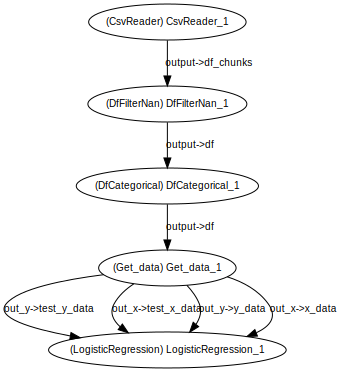

In [8]:
csv_reader = CsvReader(filepath_or_buffer="/myspace/data/titanic/train.csv")

df_filter = (DfFilterNan()
            .columns(["Age", "Cabin"])
            .df_chunks(csv_reader.output))

df_cat = (DfCategorical()
         .columns(["Sex", "Cabin", "Embarked"])
         .df(df_filter.output))

train_data = (Get_data()
             .x_columns(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Cabin', 'Embarked'])
             .y_column(['Survived'])
             .df(df_cat.output))

lr_model_train = (LogisticRegression()
         .random_state(111)
         .operation("fit")
         .x_data(train_data.out_x)
         .y_data(train_data.out_y)
         .test_x_data(train_data.out_x)
         .test_y_data(train_data.out_y)
         .attribute("n_iter_")
         .path("lr_m1.sav"))

train_pipeline = Pipeline(targets=[lr_model_train])
train_pipeline.show()

<b>Executing the training pipeline on local instance</b>

In [ ]:
train_pipeline.execute()

<b> Executing the training pipeline on Engine </b>

In [9]:
from razor.platform import engines

deployed_pipeline = engines(name='Engine-1').deploy(pipeline=train_pipeline)
running_pipeline = deployed_pipeline.execute()

In [18]:
running_pipeline.status().__dict__

{'pipeline_run_id': '39a11bcb-b84a-4ad3-a9ba-902ddb520c2c',
 'status': 'IN_PROGRESS',
 'name': 'Pipeline_1',
 'description': '',
 'project_id': '862fa216-264c-45c5-b5d0-4e837233367d',
 'engine_id': '0e738bcd-b35c-4e6f-b3e2-5d4865406a19',
 'deployed_pipeline_id': '26ccec86-c2af-4178-94d4-5631e26c673a',
 'block_statuses': {'4405ff72-6191-463b-a737-b7deae5b9973': {'name': 'CsvReader_1',
   'status': 'COMPLETED'},
  'f5560f94-9b49-4903-b891-1e95f912bac7': {'name': 'DfCategorical_1',
   'status': 'YET_TO_START'},
  '2d5df01b-4be3-4709-bcc7-1f8c161b4c30': {'name': 'DfFilterNan_1',
   'status': 'COMPLETED'}}}

In [ ]:
running_pipeline.logs(pretty=True)

In [20]:
running_pipeline.metrics().plot()

alt.VConcatChart(...)

### Running inference

#### Problem 
Load the saved model and predict on test data and save the results

#### Solution
Create an inference pipeline, to predict on test data
1. Create an instance of `LogisticRegression` class with following parameters and evaluate the model by running execute():
    * `operation` - `predict`
    * `x_data` - Test data on which the model is to be predicted.
    * `attribute` - Column name for the predicted value.
    * `path` - Specify the path where the trained model is saved.


In [ ]:
lr_model_predict = (LogisticRegression()
         .operation("predict")
         .x_data(train_data.out_x)
         .attribute("classes_")
         .path("lr_m1.sav"))

@inputs.atomic.generic("output_path", required=True)
@inputs.atomic.generic("numpy_array", required=True)
class NumpyToCsv(Block):
    def run(self, numpy_array, output_path):
        pd.DataFrame(numpy_array,columns=['Predictions']).to_csv(output_path)
        
csv_writer = (NumpyToCsv()
    .output_path("/myspace/data/lr_pred_1.csv")
    .numpy_array(lr_model_predict.predictions))

predict_pipeline = Pipeline(targets=[csv_writer])

In [ ]:
predict_pipeline.show()

<b> Run the inference pipeline in local </b>

In [ ]:
predict_pipeline.execute()

<b> Run the inference pipeline in Engine </b>

In [ ]:
from razor.platform import engines

deployed_predict_pipeline = engines(name='Engine-1').deploy(pipeline=predict_pipeline)
running_predict_pipeline = deployed_predict_pipeline.execute()

In [ ]:
running_predict_pipeline.status().__dict__

In [ ]:
running_predict_pipeline.logs(pretty=True)

In [ ]:
running_predict_pipeline.metrics()

### Evaluation of Logistic Regression model

#### Problem
The user wants evaluate the logistic regression model that is trained and saved with given metric.
#### Solution
The evaluation of the classification model comprises following parameters:

1. Create an instance of `LogisticRegression` class with following parameters and evaluate the model by running execute():
    * `operation` - `evaluate`
    * `metric_function` - Specify suitable evaluation metric from the folloeing, that best suits for the problem that you are dealing with.
         `confusion_matrix`, `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `roc_curve`  
    * `test_x_data` - Test data on which the model is to be evaluated.
    * `test_y_data` - Test target values corresponding to each data point in `test_x_data`.
    * `path` - Specify the path where the trained model is saved.

For example:

In [ ]:
lr_model_conf = (LogisticRegression()
         .operation("evaluate")
         .metric_function("confusion_matrix")
         .test_x_data(train_data.out_x)
         .test_y_data(train_data.out_y)
         .path("/tmp/lr_m1.sav"))

In [ ]:
evaluate_pipeline = Pipeline(targets=[lr_model_conf])

In [ ]:
evaluate_pipeline.execute()

In [ ]:
evaluate_pipeline.show()

2. One can compute multiple metrics by passing a list of metrics for the parameter metric_function.

For example:

In [ ]:
lr_model_metrc = (LogisticRegression()
         .operation("evaluate")
         .metric_function(["f1_score","precision_score","accuracy_score","recall_score"])
         .test_x_data(train_data.out_x)
         .test_y_data(train_data.out_y)
         .path("/tmp/lr_m1.sav"))


In [ ]:
evaluate_pipeline = Pipeline(targets=[lr_model_metrc])
evaluate_pipeline.execute()

In [ ]:
evaluate_pipeline.show()